# **Classificatin models for drowsiness detection of driver**

****

In [1]:
pip install patchify

In [2]:
"importing libraries"
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import random
from tensorflow.keras.layers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau,CSVLogger
import pickle
from glob import glob
from sklearn.utils import shuffle
from patchify import patchify
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
import os
import zipfile

# Subir kaggle.json
files.upload()

# Mover kaggle.json a la carpeta de configuración de Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la biblioteca de Kaggle
!pip install kaggle

# Descargar el dataset drowsy
!kaggle datasets download -d shivampandey1233/drowsy

# Crear una carpeta para el dataset drowsy
os.makedirs('drowsy_dataset', exist_ok=True)

# Descomprimir el archivo descargado
with zipfile.ZipFile('drowsy.zip', 'r') as zip_ref:
    zip_ref.extractall('drowsy_dataset')

# Listar los archivos descomprimidos
print("Contenido de drowsy:")
print(os.listdir('drowsy_dataset'))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shivampandey1233/drowsy
License(s): MIT
 99% 487M/493M [00:05<00:00, 90.2MB/s]
100% 493M/493M [00:05<00:00, 97.0MB/s]
Contenido de drowsy:
['Face Image']


**Extracting faces from images of three classes : ("active","yawning","drowsy").**

**Visualization of extracted face images from each class.**

-----------------------------------------------------------------------------------

			Images after extracting faces



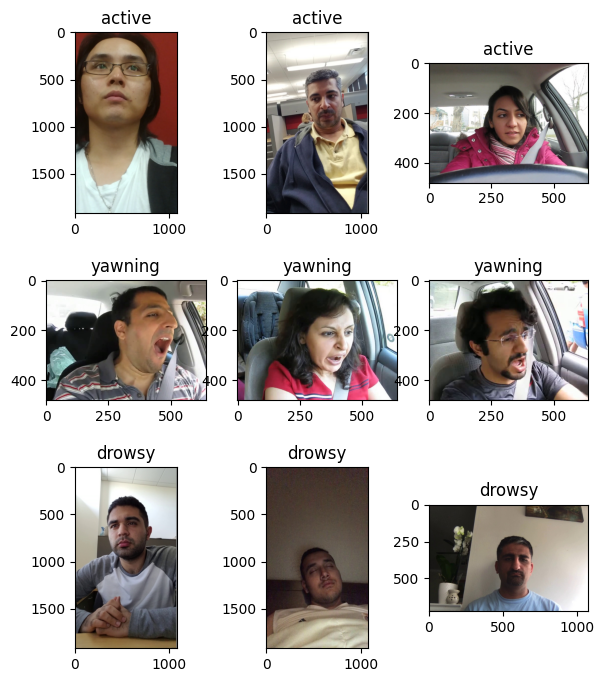

In [4]:
""" Visualization of images Before and after face extraction """

def display_images_from_classes(class_directories,class_names, num_images_to_display, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 8))

    for class_index, class_directory in enumerate(class_directories):
        image_files = [f for f in os.listdir(class_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for i in range(num_images_to_display):
            if i < len(image_files):
                image_file = image_files[i]
                image_path = os.path.join(class_directory, image_file)
                image = Image.open(image_path)

                ax = axes[class_index, i]

                ax.imshow(image)
                ax.set_title(f'{class_names[class_index]}')

        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')

    for class_index in range(len(class_directories)):
        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')

    plt.show()

print("-----------------------------------------------------------------------------------\n")
print("\t\t\tImages after extracting faces\n")
a1 = "/content/drowsy_dataset/Face_Image/active"
a2 = "/content/drowsy_dataset/Face_Image/yawning"
a3 = "/content/drowsy_dataset/Face_Image/drowsy"
# Specify the directories for the three classes
a_class_directories = [a1, a2, a3]
a_class_names = ['active','yawning','drowsy']
num_images_to_display = 3
num_rows = len(a_class_directories)  # One row for each class
num_cols = num_images_to_display
display_images_from_classes(a_class_directories, a_class_names,num_images_to_display, num_rows, num_cols)



**Splitting the face images data into train(75%), val(15%) and test(15%).**

In [5]:
def split_data_into_train_val_test(source_directory, destination_directory, train_split, validation_split, test_split):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # Loop through the class folders in the source directory
    for class_folder in os.listdir(source_directory):
        class_directory = os.path.join(source_directory, class_folder)

        # Create class-specific subdirectories in the destination directory
        train_dir = os.path.join(destination_directory, 'train', class_folder)
        validation_dir = os.path.join(destination_directory, 'validation', class_folder)
        test_dir = os.path.join(destination_directory, 'test', class_folder)

        for directory in [train_dir, validation_dir, test_dir]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        image_files = [f for f in os.listdir(class_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(image_files)

        # Split the images into train, validation, and test sets
        num_images = len(image_files)
        num_train = int(train_split * num_images)
        num_validation = int(validation_split * num_images)
        num_test = int(test_split * num_images)

        train_images = image_files[:num_train]
        validation_images = image_files[num_train:num_train + num_validation]
        test_images = image_files[num_train + num_validation:]

        # Copy the images to their respective directories
        for image in train_images:
            source_path = os.path.join(class_directory, image)
            destination_path = os.path.join(train_dir, image)
            shutil.copy(source_path, destination_path)

        for image in validation_images:
            source_path = os.path.join(class_directory, image)
            destination_path = os.path.join(validation_dir, image)
            shutil.copy(source_path, destination_path)

        for image in test_images:
            source_path = os.path.join(class_directory, image)
            destination_path = os.path.join(test_dir, image)
            shutil.copy(source_path, destination_path)

    print("Data split into train, validation, and test sets.\n")

source_directory = "/content/drowsy_dataset/Face_Image"
destination_directory = "/content/drowsy_dataset/train_val_test"
train_split = 0.7
validation_split = 0.15
test_split = 0.15

split_data_into_train_val_test(source_directory, destination_directory, train_split, validation_split, test_split)


Data split into train, validation, and test sets.



***Data loading and augmentation***

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1.0/255.0,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=15,  # Rotate images by up to 15 degrees
    width_shift_range=0.15,  # Shift width by up to 15% of the image width
    height_shift_range=0.15,  # Shift height by up to 15% of the image height
    shear_range=0.15,  # Apply shear transformations with a max of 15%
    zoom_range=0.15,  # Zoom in/out by up to 15%
    horizontal_flip=True,  # Apply horizontal flips
    fill_mode='nearest',  # Fill empty areas with the nearest pixel
    brightness_range=[0.8, 1.2],  # Adjust brightness within this range
    channel_shift_range=10,  # Randomly shift color channels
)

train_generator = train_datagen.flow_from_directory(
    "/content/drowsy_dataset/train_val_test/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    "/content/drowsy_dataset/train_val_test/validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    "/content/drowsy_dataset/train_val_test/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1853 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 399 images belonging to 4 classes.


# Vision tranformer for classification

In [7]:
""" Visoin Transformer model for classification"""
@tf.keras.utils.register_keras_serializable()
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 3

    model = ViT(config)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             2360064   ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 768)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 class_token (ClassToken)    (None, 1, 768)               768       ['tf.__operators__.add[0][

In [8]:
""" Hyperparameters """
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32
hp["lr"] = 1e-4
hp["num_epochs"] = 50
hp["num_classes"] = 3
hp["class_names"] = ["active", "drowsy", "yawning"]

hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1

def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

def process_image_label(path):
    """ Reading images """
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0

    """ Preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])

    patches = np.reshape(patches, (64, 25, 25, 3))

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    """ Label """
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels

def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Paths """
    dataset_path = "/content/drowsy_dataset/Face_Image"

    """ Dataset """
    train_x, valid_x, test_x = load_data(dataset_path)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    train_ds = tf_dataset(train_x, batch=hp["batch_size"])
    valid_ds = tf_dataset(valid_x, batch=hp["batch_size"])

    """ Model """
    vitmodel = ViT(hp)
    vitmodel.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc"]
    )

    callbacks = [
#         ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
#         CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

    history = vitmodel.fit(
        train_ds,
        epochs=hp["num_epochs"],
        validation_data=valid_ds,
        callbacks=callbacks
    )

Train: 2120 - Valid: 264 - Test: 264
Epoch 1/50
67/67 [==============================] - 100s 922ms/step - loss: 1.9862 - acc: 0.3434 - val_loss: 1.1553 - val_acc: 0.4167 - lr: 1.0000e-04
Epoch 2/50
67/67 [==============================] - 60s 890ms/step - loss: 1.0745 - acc: 0.4217 - val_loss: 0.9769 - val_acc: 0.5871 - lr: 1.0000e-04
Epoch 3/50
67/67 [==============================] - 60s 891ms/step - loss: 0.7919 - acc: 0.6151 - val_loss: 0.6787 - val_acc: 0.6591 - lr: 1.0000e-04
Epoch 4/50
67/67 [==============================] - 60s 893ms/step - loss: 0.6194 - acc: 0.7047 - val_loss: 0.6565 - val_acc: 0.7083 - lr: 1.0000e-04
Epoch 5/50
67/67 [==============================] - 60s 893ms/step - loss: 0.5134 - acc: 0.7679 - val_loss: 0.5936 - val_acc: 0.8258 - lr: 1.0000e-04
Epoch 6/50
67/67 [==============================] - 60s 893ms/step - loss: 0.4218 - acc: 0.8217 - val_loss: 0.4047 - val_acc: 0.8068 - lr: 1.0000e-04
Epoch 7/50
67/67 [==============================] - 60s 892ms/

In [59]:
vitmodel.save("vit_model.keras")

In [60]:
vitmodel.save_weights("vitweights.h5")

# Analysis and Plotting loss and accuracy values

In [13]:
"""Training loss and accuray values after each epoch"""
# epochs = hp["num_epochs"]
# Adjust the epochs list to match the actual number of epochs trained
epochs = [i for i in range(1,len(history.history['loss'])+1)]
loss_values = history.history['loss']
acc = history.history['acc']

"""Validation loss and accuray values after each epoch"""
vloss_values = history.history['val_loss']
vacc = history.history['val_acc']
# print(len(loss_values))
# print(len(epochs))

<ipython-input-14-405ee82b830b>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
<ipython-input-14-405ee82b830b>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')


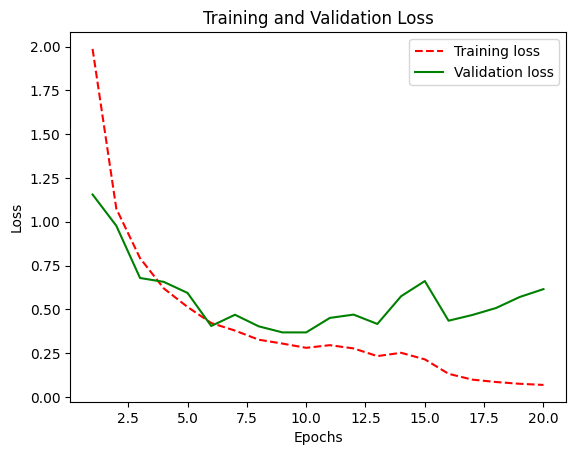

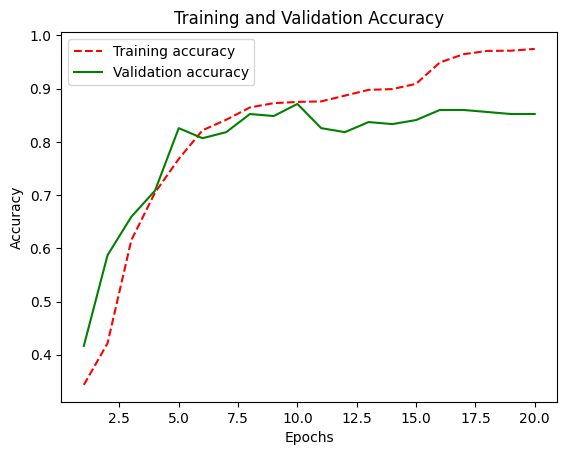

In [14]:
"""plotting values"""
# epochs = [i for i in range(len(hp['num_epochs']))]

# Plot training and validation loss
plt.plot(epochs, loss_values, '--', color = 'r',label='Training loss')
plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, acc, '--',color = 'r', label='Training accuracy')
plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
# Evaluar el modelo en el conjunto de datos de prueba
test_ds = tf_dataset(test_x, batch=hp["batch_size"])
loss_test, acc_test = vitmodel.evaluate(test_ds)
print(f'Test Loss: {loss_test}')
print(f'Test Accuracy: {acc_test}')

9/9 [==============================] - 4s 411ms/step - loss: 0.5759 - acc: 0.8788
Test Loss: 0.5759441256523132
Test Accuracy: 0.8787878751754761


In [68]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Función para cargar y mostrar imágenes desde el directorio del dataset
def load_and_display_predictions(images, labels, model, class_names, test_x, num_images=6):
    plt.figure(figsize=(20, 10))
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    labels = np.argmax(labels, axis=1)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Obtener el camino completo de la imagen
        img_path = test_x[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[preds[i]]}, True: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

# Nueva función para cargar y mostrar imágenes aleatorias
def load_and_display_random_predictions(test_ds, model, class_names, test_x, num_images=6):
    # Desempaquetar el dataset y convertirlo en una lista
    all_images, all_labels = [], []
    for images, labels in test_ds.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    # Convertir a arrays de numpy
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Seleccionar aleatoriamente un subconjunto de imágenes y etiquetas
    random_indices = random.sample(range(len(all_images)), num_images)
    selected_images = all_images[random_indices]
    selected_labels = all_labels[random_indices]
    selected_test_x = [test_x[i] for i in random_indices]

    # Llamar a la función de visualización con el subconjunto seleccionado
    with tf.device('/CPU:0'):
        load_and_display_predictions(selected_images, selected_labels, model, class_names, selected_test_x, num_images)


1/1 [==============================] - 1s 1s/step


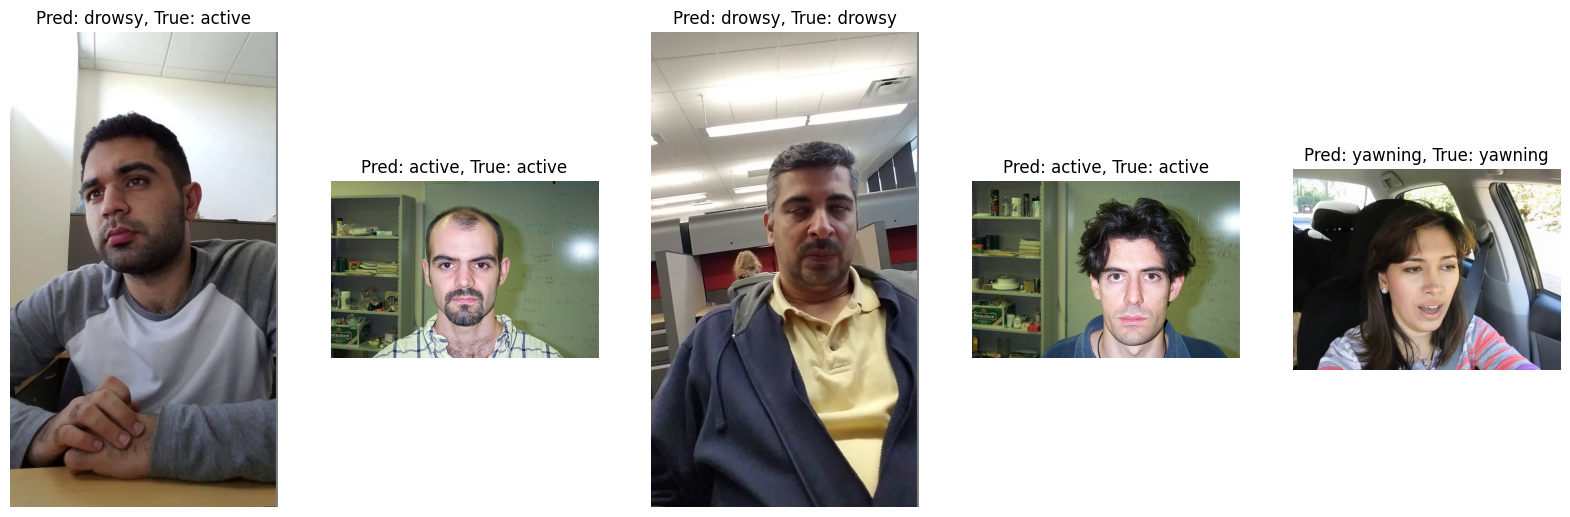

In [94]:
# Llamada a la nueva función de visualización con imágenes aleatorias
load_and_display_random_predictions(test_ds, vitmodel, hp["class_names"], test_x, num_images=5)


In [95]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns

# Función para generar reporte de clasificación y matriz de confusión
def generate_classification_report_and_confusion_matrix(test_ds, model, class_names):
    # Desempaquetar el dataset y convertirlo en una lista
    all_images, all_labels = [], []
    for images, labels in test_ds.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    # Convertir a arrays de numpy
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Obtener las predicciones para todo el conjunto de prueba
    with tf.device('/CPU:0'):
        preds = model.predict(all_images)
    preds_class = np.argmax(preds, axis=1)
    true_labels = np.argmax(all_labels, axis=1)

    # Generar el reporte de clasificación
    print("Classification Report:")
    print(classification_report(true_labels, preds_class, target_names=class_names))

    # Generar la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, preds_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Generar la matriz de confusión normalizada
    conf_matrix_normalized = confusion_matrix(true_labels, preds_class, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Calcular y mostrar Cohen's Kappa
    kappa = cohen_kappa_score(true_labels, preds_class)
    print(f"Cohen's Kappa: {kappa:.2f}")


9/9 [==============================] - 44s 5s/step
Classification Report:
              precision    recall  f1-score   support

      active       0.88      0.78      0.83        97
      drowsy       0.81      0.92      0.86        98
     yawning       0.99      0.96      0.97        69

    accuracy                           0.88       264
   macro avg       0.89      0.89      0.89       264
weighted avg       0.88      0.88      0.88       264



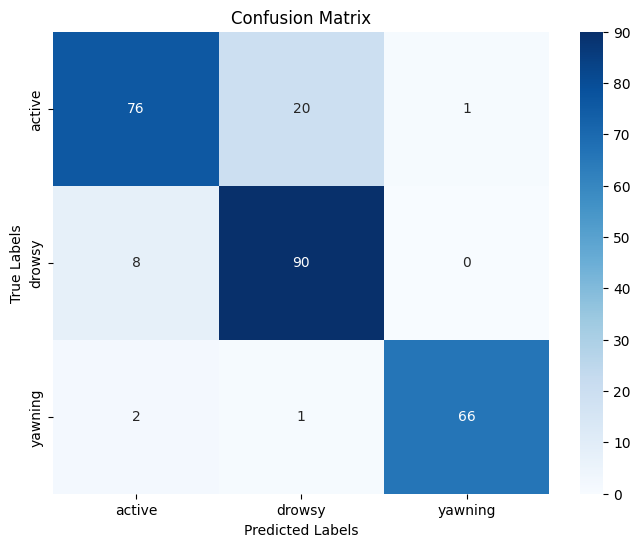

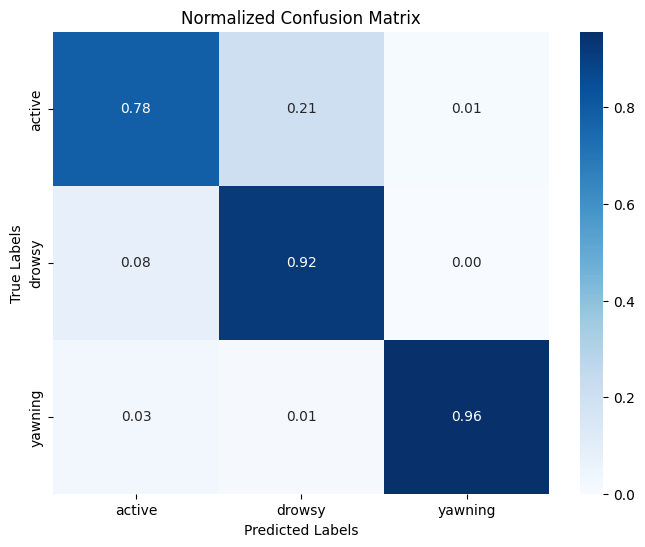

Cohen's Kappa: 0.82


In [96]:
# Llamada a la función para generar el reporte de clasificación y matriz de confusión
generate_classification_report_and_confusion_matrix(test_ds, vitmodel, hp["class_names"])


In [97]:
from sklearn.metrics import roc_curve, auc

# Función para generar y visualizar la gráfica ROC y AUC
def generate_roc_auc_curve(test_ds, model, class_names):
    # Desempaquetar el dataset y convertirlo en una lista
    all_images, all_labels = [], []
    for images, labels in test_ds.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    # Convertir a arrays de numpy
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Obtener las predicciones para todo el conjunto de prueba
    with tf.device('/CPU:0'):
        preds = model.predict(all_images)

    # Generar la gráfica ROC y calcular el AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(all_labels[:, i], preds[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    plt.figure()
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (area = {roc_auc[class_name]:.2f}) for class {class_name}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


9/9 [==============================] - 44s 5s/step


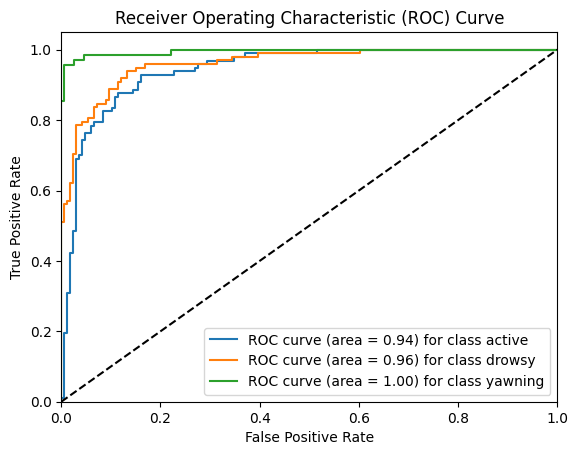

In [98]:
# Llamada a la función para generar y visualizar la gráfica ROC y AUC
generate_roc_auc_curve(test_ds, vitmodel, hp["class_names"])


In [99]:
from sklearn.metrics import precision_recall_curve

# Función para generar y visualizar las curvas de Precisión-Recall y F1-Score
def generate_precision_recall_curve(test_ds, model, class_names):
    # Desempaquetar el dataset y convertirlo en una lista
    all_images, all_labels = [], []
    for images, labels in test_ds.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    # Convertir a arrays de numpy
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Obtener las predicciones para todo el conjunto de prueba
    with tf.device('/CPU:0'):
        preds = model.predict(all_images)

    # Generar las curvas de Precisión-Recall
    precision = dict()
    recall = dict()
    for i, class_name in enumerate(class_names):
        precision[class_name], recall[class_name], _ = precision_recall_curve(all_labels[:, i], preds[:, i])

    plt.figure()
    for class_name in class_names:
        plt.plot(recall[class_name], precision[class_name], label=f'Precision-Recall curve for class {class_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    # Calcular y mostrar F1-Score
    f1_scores = {}
    for i, class_name in enumerate(class_names):
        f1_scores[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name] + 1e-10)
    print("F1-Scores:")
    for class_name, f1 in f1_scores.items():
        print(f"{class_name}: {np.mean(f1):.2f}")


9/9 [==============================] - 44s 5s/step


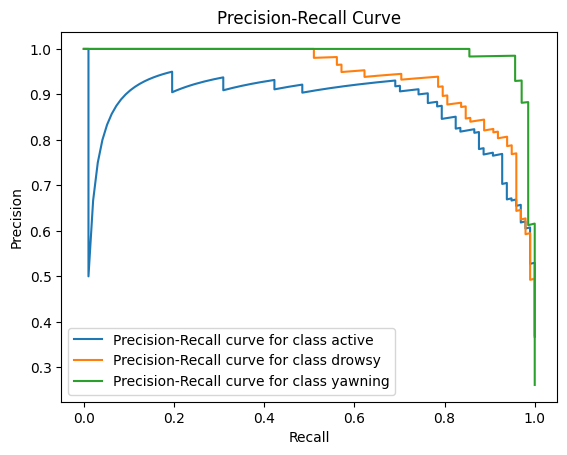

F1-Scores:
active: 0.64
drowsy: 0.72
yawning: 0.64


In [100]:
# Llamada a la función para generar y visualizar las curvas de Precisión-Recall y F1-Score
generate_precision_recall_curve(test_ds, vitmodel, hp["class_names"])
